In [1]:
import lightkurve as lk
import numpy as np
import pandas as pd
import glob
from astropy.io import ascii
from astropy.table import Table, join
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import starspot as ss
from starspot import sigma_clipping

# Functions 
#### -- amend to print something if tic not in my sample

In [2]:
#og
def plot_sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for sec in sectors:
        try:
            lcsectorpath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            lcfile = lk.open(lcsectorpath)
            lcfile.scatter()
            plt.title('TIC:{},sector:{}'.format(tic,sec))
        except:
            print('nothing for tic:{} sector:{}'.format(tic,sec))
            
#remix---only does 1st sector from every tic
def plot_1sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    count = 0
    for sec in sectors:
        lcsectorpaths = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
        if count % 2 == 0:
            try:
                lcfile = lk.open(lcsectorpaths)
                lcfile.scatter()
                plt.title('TIC:{},sector:{}'.format(tic,sec))
                count +=1
            except FileNotFoundError:
                print('nothing for tic:{} sector:{}'.format(tic,sec))
                count +=2
        else:
            continue

#plot one sector & change lims  --will stop whenever first sector with data is found         
def plot_sector_altax(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for sec in sectors:
        count=0
        try:
            count=+1
            lcsectorpath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            lcfile = lk.open(lcsectorpath)
            lcfile.scatter()
            plt.title('TIC:{},sector:{}'.format(tic,sec))
        except:
            print('nothing for tic:{} sector:{}'.format(tic,sec))
        if count == 1: ### will stop after finding the first sector
            print('Time Range:{}-{}'.format(np.min(lcfile.time), np.max(lcfile.time)))
            break
    return lcfile.time

# unique item finder

def uniquefinder(mylist):
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('there are {} unique tics. Use the first output dictionary'.format(uniques), \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a


# Plots highest amp RP of each sector for ALL SECTORS
def plot_rps(tic,plot=False):
    plt.figure(figsize=(10,5))
    if type(tic)==np.int64: #must be integer
        tic=tic
    else:
        tic=np.int64(tic) #mustve changed allstats table to have IDs that are integers so gotta change fcn to match that
    secs=[]
    rps=[]
    amps=[]
    rvars=[]
    for row in cvzsecs:
# maybe just make given tic & pulled tics datatype match here tic = tic if type(tic) == type(ticid) else tic.dtype == type(ticid)
        ticid = row['ID'] 
        if ticid == tic:
            sec = row['sector']
            rp = row['ls1']
            amp = row['lsamp1']
            rvar = row['rvar']
            secs.append(sec)
            rps.append(rp)
            amps.append(amp)
            rvars.append(rvar)
        else:
            continue
    #summary stats
    if len(rps)==0:
        mytable = 'No stats for TIC {}'.format(tic)
        if plot==True:
            print('No stats to plot. rps: {}, secs: {}, amps: {}, rvars: {}'.format(len(rps),len(secs),len(amps),len(rvars)))
    else:
        print('Average LS1 Rotation Period for TIC {} is:'.format(tic),np.mean(rps))
        mytics = np.repeat(tic,len(secs))
        mytable = Table([mytics,secs,rps,amps,rvars],names=('ID','sector','lsrp1','lsamp1','rvar'))
        print('Highest Amplitude from sector:',int(mytable[mytable['lsamp1']==np.max(mytable['lsamp1'])]['sector']))
        #comparison from stitiched lc
        ########################################
        #maybe put a conditional to verify get right table, for now rely on print statemtn of tic matching
        #ogtt = cvzstats[cvzstats['ID']==str(tic)] #must match dtype for allstats['ID']--fixed above in ifelse
        ogtt = cvzstats[cvzstats['ID'] == tic]
        print('verify:',ogtt['ID'][0],'matches:',tic)
        ########################################
        #plotting
        plt.scatter(mytable['sector'],mytable['lsrp1'],s=15,c=mytable['lsamp1'],vmax=0.05,vmin=0.0,label='RP per sector');   
        #NOTE: below ['NUMsectors'] is the total number of sectors available,values from stitched lcs
        plt.scatter([ogtt['TOTsecs']],[ogtt['ls1']],s=55,marker="^",c=[ogtt['lsamp1']],vmax=0.05,vmin=0.0,label = 'stitched lcs RP')
        print('Stitched LS1 RP: ',ogtt['ls1'][0])
        print('Stitched ACF1 RP:',ogtt['acf1'][0])
        print('Stitched ACF-2 rp:',ogtt['acf2'][0])
        print('stitched ls-2 rp:',ogtt['ls2'][0])
        plt.xlabel('sector',fontsize=15)
        plt.ylabel('lsrp1',fontsize=15)
        plt.colorbar().set_label(label='ls amplitude',size=15)
        plt.grid('on')
        plt.legend()
        plt.title('EACH sectors rp for CVZ TIC:{}'.format(tic),fontsize=20)
        if plot == True:
            #to plot lcs of above
            sector = [1,2,3,4,5,6,7,8,9,10,11,12,13]
            tic = tic
            for sec in sector:
                path = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
                try:
                    lc = lk.open(path)
                    lc.scatter()
                    plt.title('TIC: {}, SEC: {}'.format(tic,sec))
                except:
                    pass
    return mytable

## Load Data

In [3]:
# load data

#stats
secstats = ascii.read('data/bigstats_by_sector.fits') #og/add/ext tics
# allstats = ascii.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics
allstats = ascii.read('data/master_bls_bigstats_stitchedlcs.fits')#all stats for all tics

mq = pd.read_csv('data/mcquillan_sample.csv') #mq data for comparisons
#tic lists 
alltics = np.load('data/all_dled_tics.npy') # list of new+old tics
goodtics = np.load('data/good_cvz_tics.npy') #only 10+ sectors

#CUTS to data
cvzstats = allstats[allstats['TOTsecs']>=10]
print(len(cvzstats),len(goodtics),'these should be the same, but some couldnt run bls on')
cvzsecs = secstats[secstats['NUMsectors']>=10]
print('Number of "CVZ"(10+sectors) targets:', len(cvzsecs))

5993 6009 these should be the same, but some couldnt run bls on
Number of "CVZ"(10+sectors) targets: 70865


# check star here

In [5]:
# get stitchecd stats on one star

tic = 149603524
print('this run uses TIC {}'.format(tic))
allstats[allstats['ID']==tic]

this run uses TIC 149603524


ID,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,acf2,acf3,acfamp1,acfamp2,acfamp3,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,power,period,depth,transit_time,duration
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str12,str10,str16,str1,str19,str19,str8,int64,str4,str10,float64,float64,str10,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str5,str1,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64
149603524,12,0.0034569859504699485,5.360226932836758,3.334053496090116,5.850111621245946,0.013303566468243978,0.013274880798719324,0.011979868255980615,0.0694445,4.41111464,26.4722434,0.5624178653314038,0.2623845371185038,0.257985583233847,20190415,--,8900-00874-1,131-006781,05483359-6359183,N,J054833.56-635918.1,4756649415309914240,29848754,--,STAR,tmgaia2,87.1399740872908,-63.988440787086,tmgaia2,-15.6405,0.0371897,26.0463,0.0365854,gaia2,5.66486,0.0189104,gaia2,273.415812449388,-31.0335697980936,63.7531796047894,-87.1638479174296,10.734,0.078,10.213,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.272,0.024,9.008,0.024,8.944,0.021,AAA-222-111-000-0-0,nan,8.896,0.023,8.917,0.02,8.87,0.022,9.165,0.307,10.0721,0.000305,9.7109,0.006,rered,spect,6391.0,115.876,4.37665,0.0797224,0.24,0.05,1.21427,0.0542211,1.28,0.190812,0.714926,0.150172,DWARF,2.21616721,0.1061619,175.631,0.588,0.0202575,0.01075925,971,0.0163922813,N/A,N,0.00709071476,0.0109007,0.0106178,schlegel,0.160421,0.221203,0.0500111,0.0584312,0.129424,0.170919,0.0597669,0.0996779,0.0974178,0.114906,0.586,0.59,bj2018,102.407,129.345,spect,10.355,0.00104,9.67009,0.001594,1,N,tycho2v3,tycho2b3,N/A,0.679915272702027,0.567409162263974,87.1398205343019,-63.9883286433749,0.0177794575227992,0.019508362038221,1,0,553086869,8979,4.412088241764836,0.010469629162653586,0.7839999999999999,0.16


In [6]:
# get sectors stats on one star

tic = 149603524 #25063396
print('this run uses TIC {}'.format(tic))
secstats[secstats['ID']==tic]

this run uses TIC 149603524


ID,NUMsectors,sector,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,acf1,acf2,acf3,acfamp1,acfamp2,acfamp3
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str12,str10,str16,str1,str19,str19,str8,int64,str4,str10,float64,float64,str10,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str5,str1,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64
149603524,12,1,0.0032229304313660108,6.262893861676344,3.3852294192919383,8.559960555307311,0.03422780476052554,0.033875826165596104,0.020106408206558613,20190415,--,8900-00874-1,131-006781,05483359-6359183,N,J054833.56-635918.1,4756649415309914240,29848754,--,STAR,tmgaia2,87.1399740872908,-63.988440787086,tmgaia2,-15.6405,0.0371897,26.0463,0.0365854,gaia2,5.66486,0.0189104,gaia2,273.415812449388,-31.0335697980936,63.7531796047894,-87.1638479174296,10.734,0.078,10.213,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.272,0.024,9.008,0.024,8.944,0.021,AAA-222-111-000-0-0,nan,8.896,0.023,8.917,0.02,8.87,0.022,9.165,0.307,10.0721,0.000305,9.7109,0.006,rered,spect,6391.0,115.876,4.37665,0.0797224,0.24,0.05,1.21427,0.0542211,1.28,0.190812,0.714926,0.150172,DWARF,2.21616721,0.1061619,175.631,0.588,0.0202575,0.01075925,971,0.0163922813,N/A,N,0.00709071476,0.0109007,0.0106178,schlegel,0.160421,0.221203,0.0500111,0.0584312,0.129424,0.170919,0.0597669,0.0996779,0.0974178,0.114906,0.586,0.59,bj2018,102.407,129.345,spect,10.355,0.00104,9.67009,0.001594,1,N,tycho2v3,tycho2b3,N/A,0.679915272702027,0.567409162263974,87.1398205343019,-63.9883286433749,0.0177794575227992,0.019508362038221,1,0,553086869,0.0694445,8.82222928,4.4166702,0.2995916888426424,0.13217171876775655,0.10634266143758543
149603524,12,2,0.0032150447368621826,3.2803486126938948,3.898131450984794,5.442246843193152,0.06918488089647844,0.05572781637143137,0.03633898063328745,20190415,--,8900-00874-1,131-006781,05483359-6359183,N,J054833.56-635918.1,4756649415309914240,29848754,--,STAR,tmgaia2,87.1399740872908,-63.988440787086,tmgaia2,-15.6405,0.0371897,26.0463,0.0365854,gaia2,5.66486,0.0189104,gaia2,273.415812449388,-31.0335697980936,63.7531796047894,-87.1638479174296,10.734,0.078,10.213,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.272,0.024,9.008,0.024,8.944,0.021,AAA-222-111-000-0-0,nan,8.896,0.023,8.917,0.02,8.87,0.022,9.165,0.307,10.0721,0.000305,9.7109,0.006,rered,spect,6391.0,115.876,4.37665,0.07

this run uses TIC 140801898
Average LS1 Rotation Period for TIC 140801898 is: 0.7685516435005747
Highest Amplitude from sector: 5
verify: 140801898 matches: 140801898
Stitched LS1 RP:  0.7685964934125241
Stitched ACF1 RP: 0.76805617
Stitched ACF-2 rp: 1.53750123
stitched ls-2 rp: 0.7664619273092502
Mean of rps less than 5 is:  0.7685516435005747


ID,sector,lsrp1,lsamp1,rvar
int64,int64,float64,float64,float64
140801898,1,0.7679887417868543,0.16252850390735307,0.029199814796447843
140801898,2,0.7686783795974729,0.1781068030625028,0.02979824542999265
140801898,3,0.7684795434079242,0.21788714015141247,0.030784597992897126
140801898,4,0.7687368804130188,0.2806437333499162,0.033896088600158684
140801898,5,0.768526319138664,0.3158643898574373,0.03433780372142792
140801898,6,0.7681522726549959,0.2924688405764044,0.03319685161113739
140801898,7,0.7686900790482661,0.25887898630648193,0.032363873720169016
140801898,8,0.7687485816446834,0.21658118930899925,0.03205903172492985
140801898,9,0.7689592647445569,0.16297449855155913,0.029845136404037412


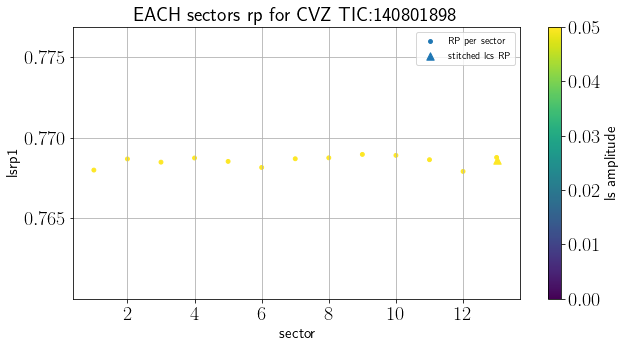

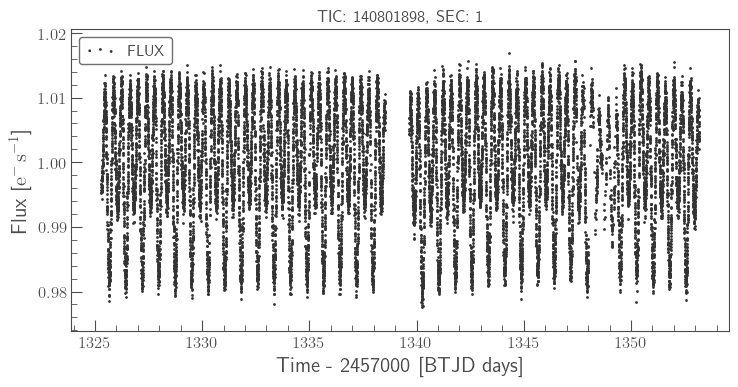

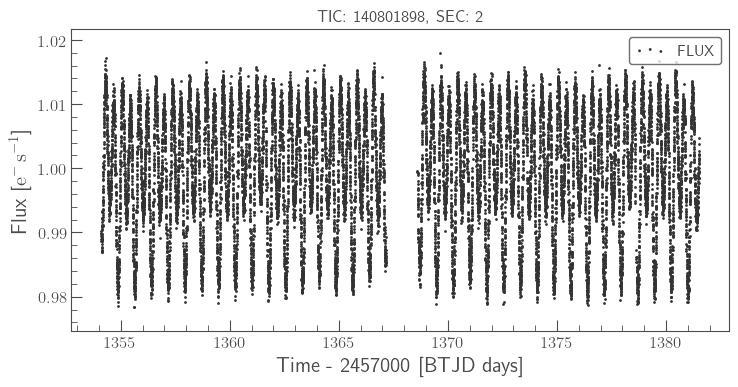

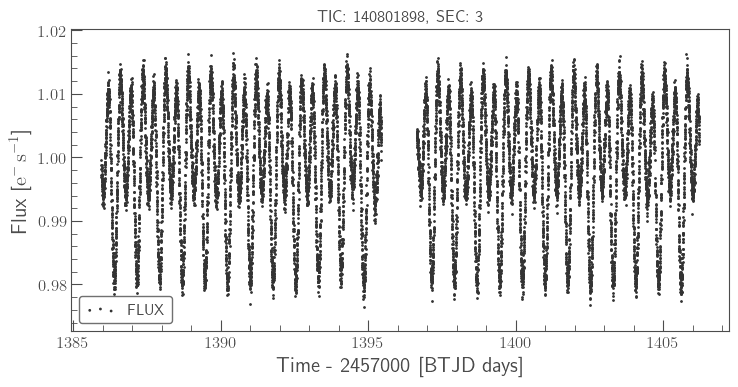

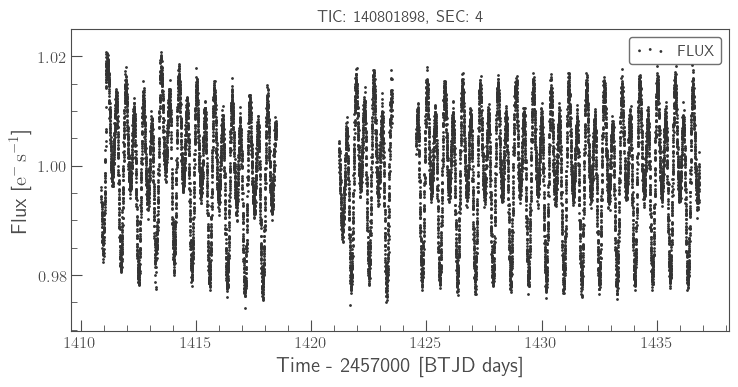

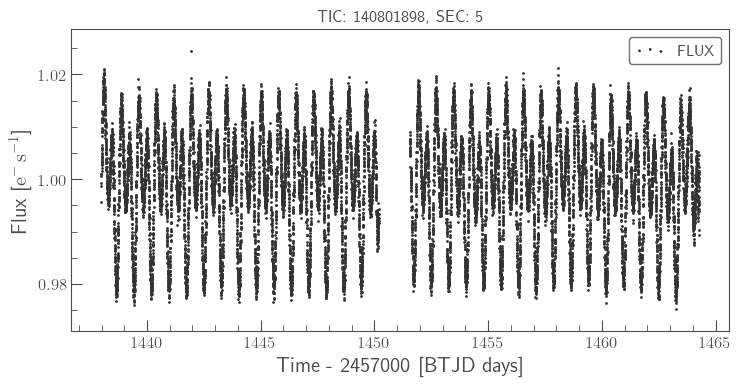

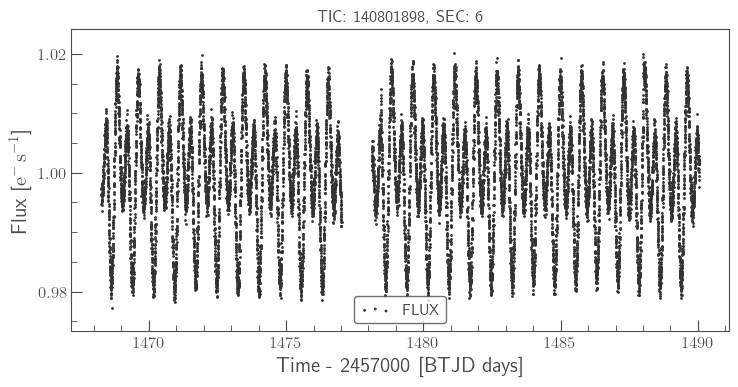

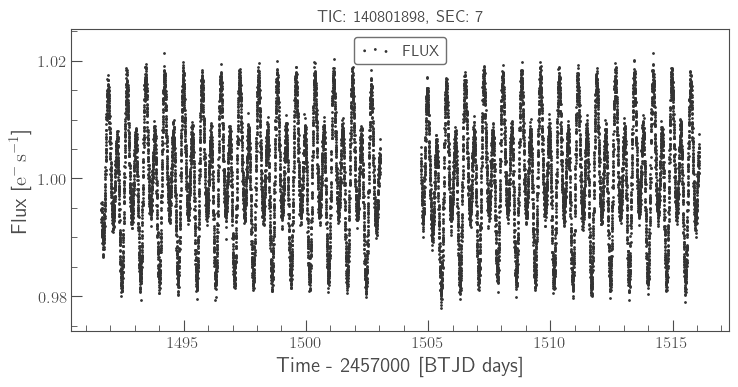

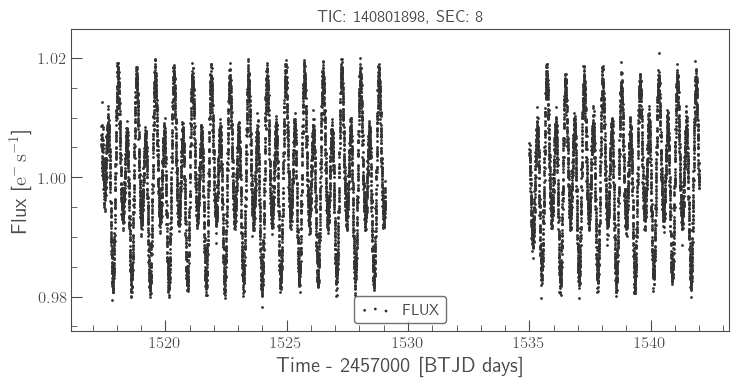

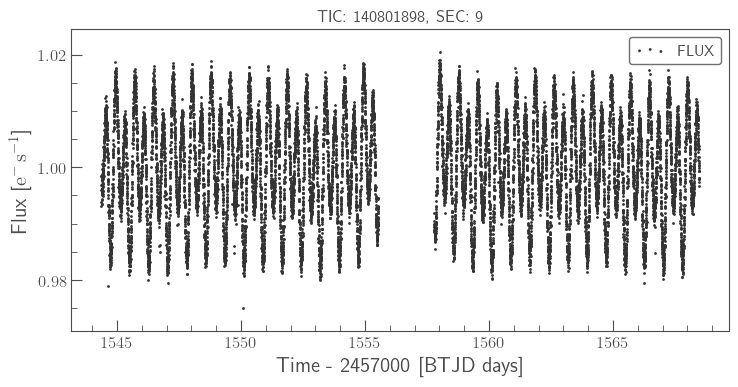

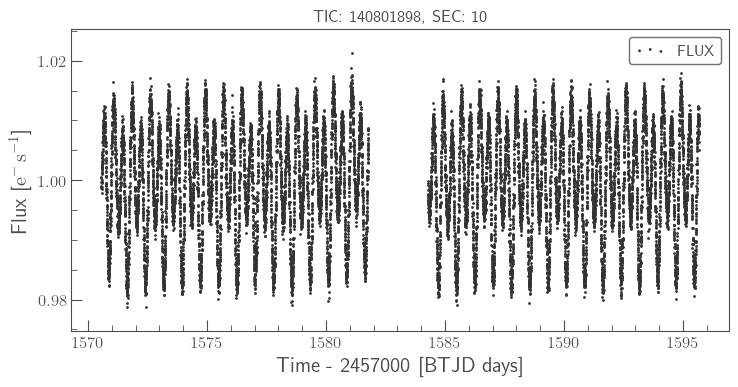

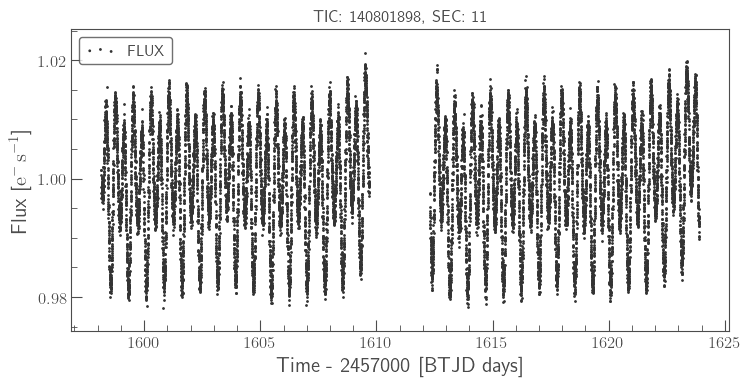

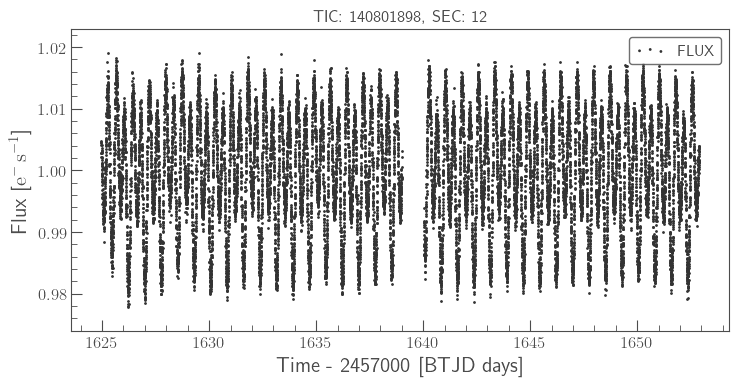

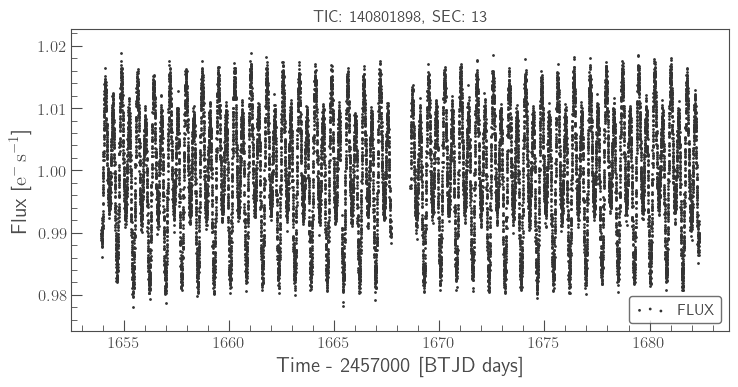

In [4]:
# plot each sector and sector stats

tic =  140801898 #25063396
print('this run uses TIC {}'.format(tic))
myt = plot_rps(tic,plot=True)
limit = 5
shortmyt = myt[myt['lsrp1']<limit]
avg = np.mean(shortmyt['lsrp1'])
print('Mean of rps less than', limit,'is: ',avg)
myt

Time Range:1325.2965604667204-1353.1770258833596
times: [1325.29656047 1325.29794935 1325.29933824 ... 1353.17424813 1353.17563701
 1353.17702588]
limits: 1325.2965604667204 1325.310449338699 18104 1325


(1325, 1335)

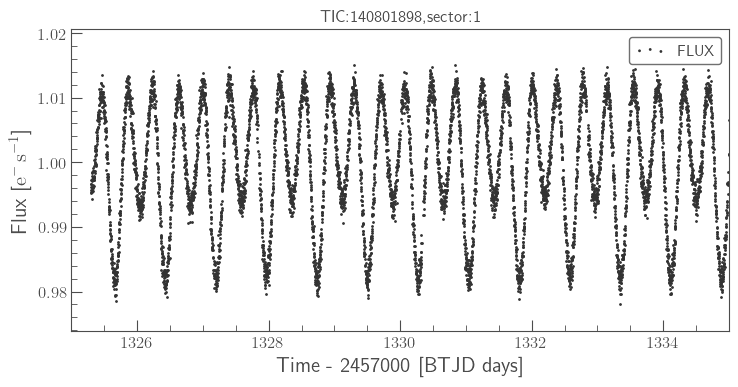

In [16]:
# check one sector so can change axes lims

tic = 140801898
            
times = plot_sector_altax(tic)
print('times:',times)
print('limits:',times[0],times[0+10],len(times),int(times[0]))
plt.xlim(int(times[0]),int(times[0])+10);
# plt.xlim(1326,1328);

In [49]:
test_Periods= np.linspace(0,27,25)
sn = np.random.randn(len(test_Periods))
per_accuracy = sn<0.
# print(len(test_Periods),len(sn),len(per_accuracy),per_accuracy)
per_accuracy = sn<0.
mydata = {'injected_period': test_Periods,'sn':sn,'accuracy':per_accuracy}
mydf = pd.DataFrame(data=mydata)
myarr = mydf.to_numpy()
for i in myarr:
    print(i,'next')
# np.shape(myarr) #25x3
for i in myarr[0:,0]: #inj_periods
    print(i)

[0.0 1.8894007273078302 False] next
[1.125 -0.26210144795076695 True] next
[2.25 -0.380917473708822 True] next
[3.375 0.49418472396876173 False] next
[4.5 -0.1940665696999345 True] next
[5.625 -1.120334925548812 True] next
[6.75 -1.7750110915048882 True] next
[7.875 -1.3905535801814355 True] next
[9.0 0.6617347400238088 False] next
[10.125 -0.5141209685256778 True] next
[11.25 -0.8615265988327113 True] next
[12.375 -0.6705073679283509 True] next
[13.5 0.14154813556851156 False] next
[14.625 0.5539731030774757 False] next
[15.75 1.5822061764239437 False] next
[16.875 -0.053480416787927934 True] next
[18.0 -0.4481316728769476 True] next
[19.125 -0.7113593036501737 True] next
[20.25 0.41745168353379364 False] next
[21.375 -0.908431966036969 True] next
[22.5 0.4609968089486158 False] next
[23.625 -0.6323931540275332 True] next
[24.75 -1.8231839814638053 True] next
[25.875 -0.7697847169691958 True] next
[27.0 0.09437510916150178 False] next
0.0
1.125
2.25
3.375
4.5
5.625
6.75
7.875
9.0
10.1

# Check multiple stars 

nothing for tic:30630877 sector:1
nothing for tic:30631031 sector:1


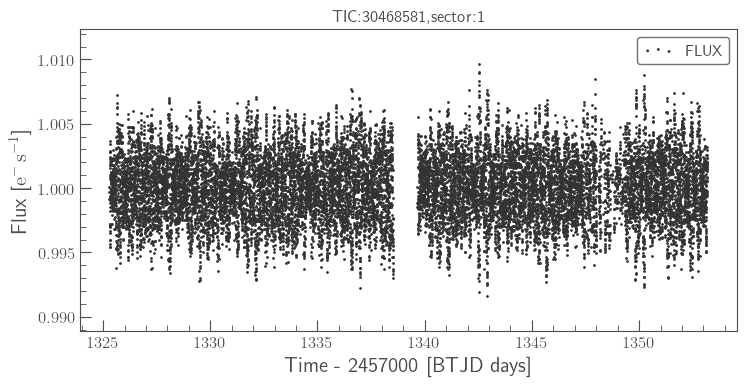

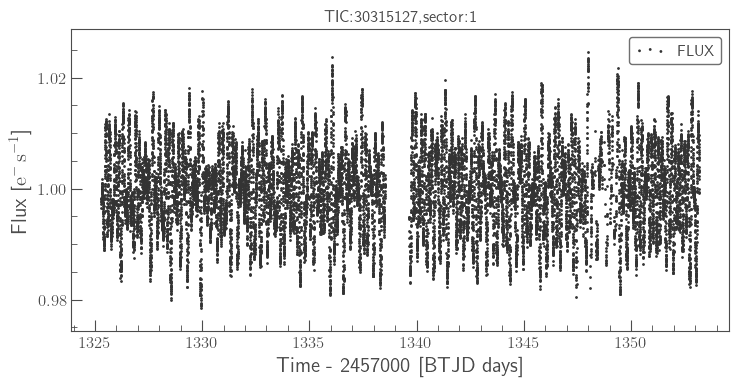

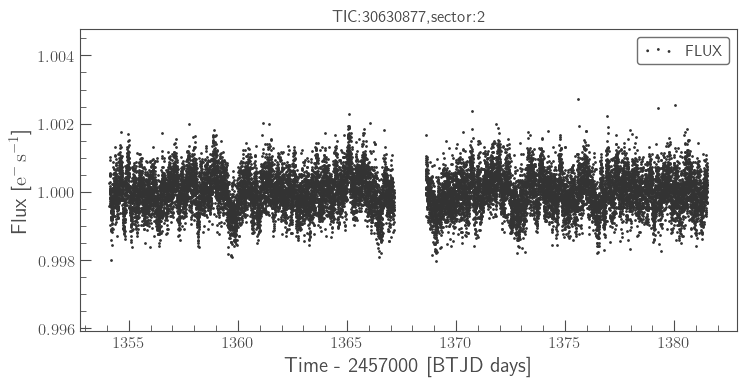

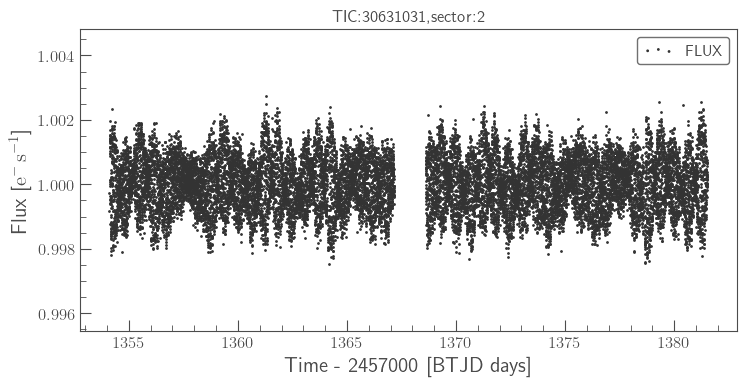

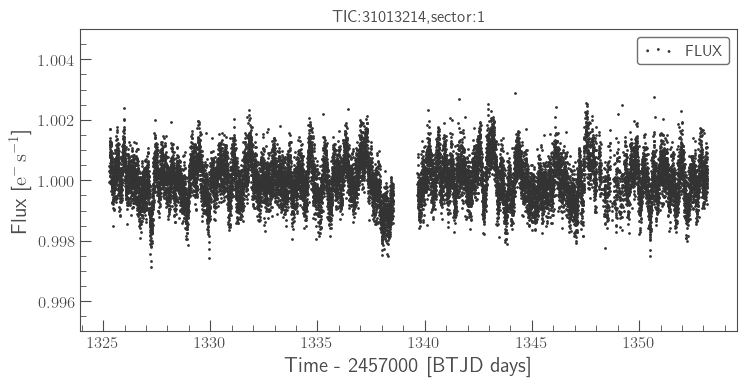

In [76]:
# check many stars' first sectors

# tics = [348897766,309659126,30631330,55524055,140801898,260654645]# definitely EBs
# tics = goodtics[180:200] #alltics[0:20] #
tics = [30468581,30315127,30630877,30631031,31013214] #the idks


for tic in tics:
    plot_1sector(tic)

# Check a periodogram

In [45]:
def rp_plot(tic,measure):
    ''' make measure a string; requires numpy as np'''
    if measure == 'acf':
        x_model,y_model,labels = 'acf_lags.npy','acf_ys.npy',['Lags','Power']
    elif measure == 'ls':
        x_model,y_model,labels = 'ls_freq.npy','ls_power.npy',['Frequency','Power']
    else:
        print('Model type not understood')
    try:
        xdata= np.load('data/FOURTHRUN/data_arrs/{}/{}'.format(tic,x_model))
        ydata= np.load('data/FOURTHRUN/data_arrs/{}/{}'.format(tic,y_model))
        plt.figure(figsize=(11,5))
        plt.plot(xdata,ydata)
        plt.title('{} for {}'.format(measure, tic),fontsize=20)
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
        return xdata,ydata
    except Exception as e:
        print('Check second index output for error')
        return 'Error for tic {}'.format(tic),e

In [46]:
xx,yy=rp_plot(999,'acf')
# plt.xlim(0,5)

Check second index output for error


In [47]:
yyy =rp_plot(999,'acf')

Check second index output for error


In [48]:
yyy

('Error for tic 999', FileNotFoundError(2, 'No such file or directory'))

# TESTS

In [80]:
.578*3

1.734

In [9]:
tics_list = np.load('data/all_dled_tics.npy') 
print(len(tics_list))

24084


			starting work on tic: 149603524  and with count:   0
TIC 149603524 didnt work due to err: 'int' object is not subscriptable
			starting work on tic: 900000  and with count:   1
TIC 900000 didnt work due to err: [Errno 2] No such file or directory: 'data/SECONDRUN/cleaned_LightCurves/900000/lc.fits'


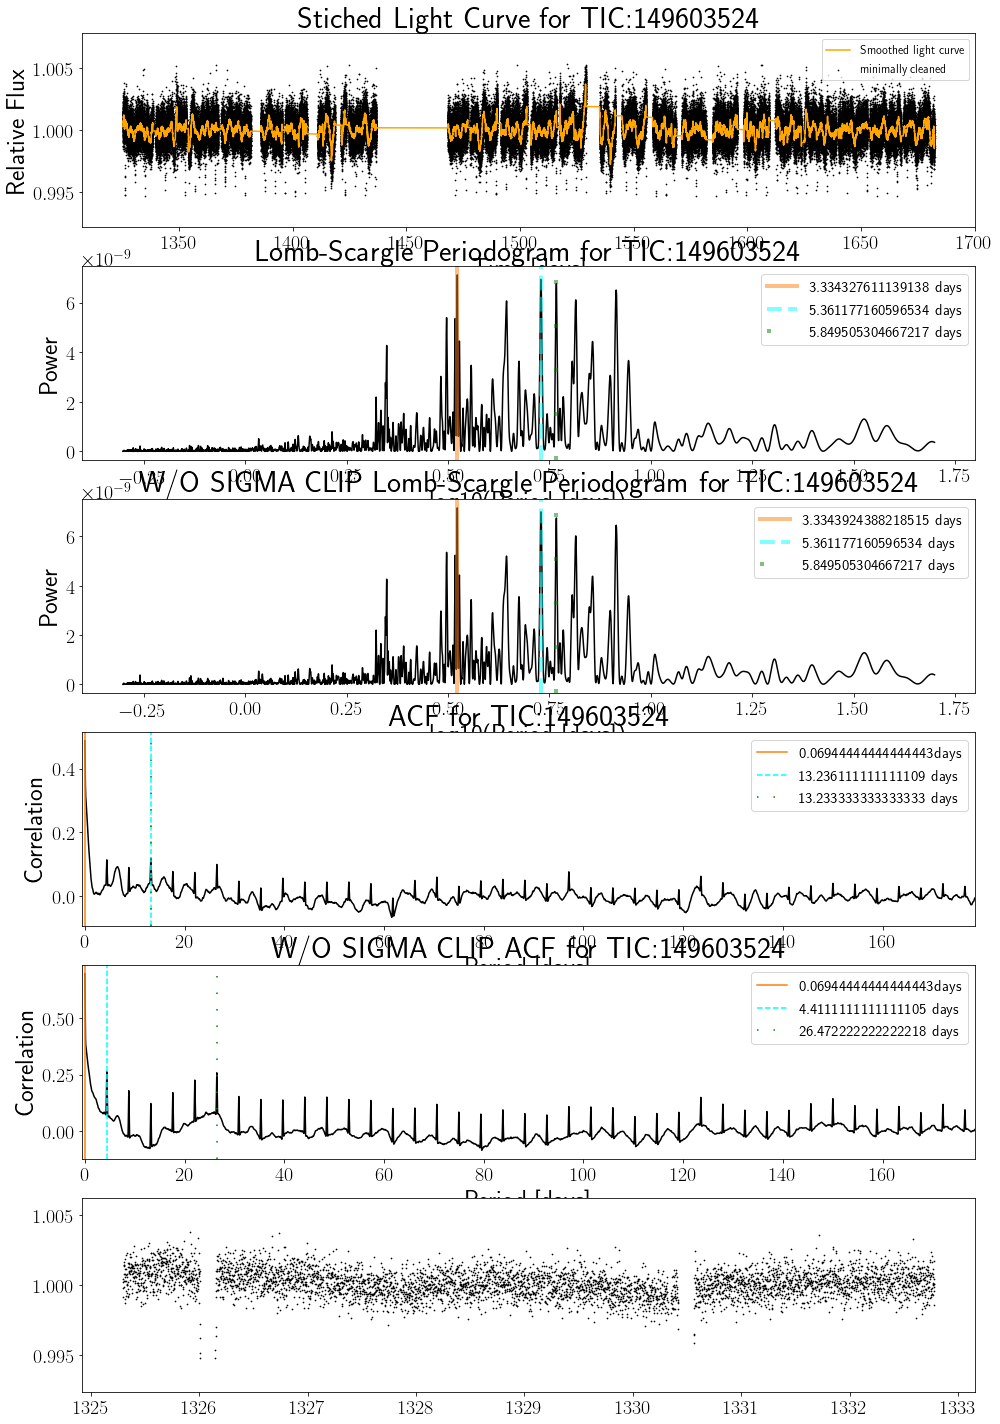

In [75]:
#this whole cell to test if additional sigmclip below is useful or harmful for ls/acf
## measurements -- SECONDRUN didnt use ruths sigmaclip from sspot; based on transits
## the sigma clip removes those so ls/acf more likely to pick up stellar rot but still 
## chance of planet period caught; if astro signal present it doesnt seem to change
## what is measured; sometimes peak heigth order changes but thats mostly on flats 
## that already had unreliable measurements; so overall using this extra sigmaclip during
## FOURTH_RUN.py is ok


tics_list = [25063396,990000,149603524,900000,118195419, 141268467,141186325] #good,bad,good,bad tics ##examples to test code
#flat, bad, planet transit, bad, good astro, eb/planet? with strong astro, astro but spots move,

#to store calculated stats
tic_list = [] #to verify picking order stays same
err_stmts=[]
pdms_err =[] 
pdms =[]

#opening cleaned lcfiles
for count,tic in enumerate(tics_list[2:4]):
	print('			starting work on tic:',tic, ' and with count:  ',count)
	try: 
		lc = fits.open('data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)) #lk cant find flux attribute
		data = lc[1].data #all the data
		flux1 = data['FLUX']
		flux_err1 = data['FLUX_ERR']
		time1 = data['TIME']
		cadence = data['CADENCENO']
		quality = data['QUALITY']
#extra cleaning- ruths tutorial
    # Calculate the median so that we can median-normalize.
		med = np.median(flux1)
    # Do an initial sigma clip to remove big outliers.
		m = sigma_clipping.sigma_clip(flux1/med - 1, nsigma=5)
		x, y, yerr = time1[m], flux1[m]/med - 1, flux_err1[m]/med

    # Then a sigma clip using a Sav-Gol filter for smoothing
		smooth, mask = sigma_clipping.filter_sigma_clip(x, y, window_length=199)
		time, flux, flux_err = x[mask], y[mask], yerr[mask]

		rotate = ss.RotationModel(time, flux, flux_err) #with ruths sigma clip
		rotate1 = ss.RotationModel(time1, flux1, flux_err1) #w/o extra sigma clip
#ls
		ls_period = rotate.ls_rotation(high_pass=True) #added highpass filter
		power = rotate.power
		freq = rotate.freq
		ps = 1./freq
		peaks = np.array([i for i in range(1, len(ps)-1) if power[i-1] < \
                power[i] and power[i+1] < power[i]])
		peak_amps_low2high = np.sort(power[peaks])
		second_rp = ps[power == peak_amps_low2high[-2]][0]
		third_rp = ps[power == peak_amps_low2high[-3]][0]
#ls1    
		ls_period1 = rotate1.ls_rotation(high_pass=True) #added highpass filter
		power1 = rotate1.power
		freq1 = rotate1.freq
		ps1 = 1./freq1
		peaks1 = np.array([i for i in range(1, len(ps1)-1) if power1[i-1] < \
                power1[i] and power1[i+1] < power1[i]])
		peak_amps_low2high1 = np.sort(power1[peaks1])
		second_rp1 = ps1[power1 == peak_amps_low2high1[-2]][0]
		third_rp1 = ps1[power1 == peak_amps_low2high1[-3]][0]
#acf
		tess_cadence = 1./24./30.
		acf_rp = rotate.acf_rotation(tess_cadence) # tess cadence equivalent to interval = 'TESS' in starspot docs
		x2 = rotate.lags
		y2 = rotate.acf
		peaks2 = np.array([i for i in range(1,len(y2)-1) if y2[i-1] < y2[i] and \
                     y2[i+1] <y2[i]])
		x_peaks = x2[peaks2]
		y_peaks = y2[peaks2]
		inds = np.argsort(y_peaks)
		xpeaks = x_peaks[inds][::-1]
		if len(xpeaks) >= 2:
			acfrp2 = xpeaks[1]
		else:
			acfrp2 = acf_rp
		if len(xpeaks) >= 3:
			acfrp3 = xpeaks[2]
		else:
			acfrp3 = acf_rp
#acf1
		acf_rp1 = rotate1.acf_rotation(tess_cadence) # tess cadence equivalent to interval = 'TESS' in starspot docs
		x2_1 = rotate1.lags
		y2_1 = rotate1.acf
		peaks2_1 = np.array([i for i in range(1,len(y2_1)-1) if y2_1[i-1] < y2_1[i] and \
                     y2_1[i+1] <y2_1[i]])
		x_peaks_1 = x2_1[peaks2_1]
		y_peaks_1 = y2_1[peaks2_1]
		inds_1 = np.argsort(y_peaks_1)
		xpeaks_1 = x_peaks_1[inds_1][::-1]
		if len(xpeaks_1) >= 2:
			acfrp2_1 = xpeaks_1[1]
		else:
			acfrp2_1 = acf_rp1
		if len(xpeaks_1) >= 3:
			acfrp3_1 = xpeaks_1[2]
		else:
			acfrp3_1 = acf_rp1
#plots
    
		fig, axs = plt.subplots(6,1,figsize=(16,25))
# 		plt.subplots_adjust(hspace=0.5)
		axs[0].scatter(time1,flux1,color='k',s=.5,label='minimally cleaned')
		axs[0].plot(x, smooth+1,color='orange', label="Smoothed light curve")
		axs[0].set_xlabel('Time [days]')
		axs[0].set_ylabel('Relative Flux')
		axs[0].set_title('Stiched Light Curve for TIC:{}'.format(tic),fontsize=30);
		axs[0].legend(prop={'size': 12})
    
		axs[1].plot(-np.log10(freq), power, "k", zorder=0)
		axs[1].axvline(np.log10(ls_period), color="C1", lw=4, alpha=0.5,
                    zorder=1,label=('{} days'.format(ls_period)))
		axs[1].axvline(np.log10(second_rp),lw=4,alpha=0.5,zorder=2,linestyle='--',color='cyan',label=('{} days'.format(second_rp)))
		axs[1].axvline(np.log10(third_rp),lw=4,alpha=0.5,zorder=3,linestyle=(0, (1, 10)),color='g',label=('{} days'.format(third_rp)))
		axs[1].set_xlabel("log10(Period [days])")
		axs[1].set_ylabel("Power");
		axs[1].set_title('Lomb-Scargle Periodogram for TIC:{}'.format(tic),fontsize=30)
		axs[1].legend(prop={'size': 15})

		axs[3].plot(x2,y2,color='k')
		axs[3].axvline(acf_rp,color="C1",label='{}days'.format(acf_rp))
		axs[3].axvline(acfrp2,color='cyan',linestyle='--',label='{} days'.format(acfrp2))
		axs[3].axvline(acfrp3,color='green',linestyle=(0, (1, 10)),label="{} days".format(acfrp3))
		axs[3].set_xlabel("Period [days]")
		axs[3].set_ylabel("Correlation")
		axs[3].set_xlim(-0.5,max(x2))#acfrp3+5)
		axs[3].set_title('ACF for TIC:{}'.format(tic),fontsize=30)
		axs[3].legend(prop={'size': 15})
    
#w/o extra sigma clipping plots
		axs[2].plot(-np.log10(freq1), power1, "k", zorder=0)
		axs[2].axvline(np.log10(ls_period1), color="C1", lw=4, alpha=0.5,
                    zorder=1,label=('{} days'.format(ls_period1)))
		axs[2].axvline(np.log10(second_rp1),lw=4,alpha=0.5,zorder=2,linestyle='--',color='cyan',label=('{} days'.format(second_rp1)))
		axs[2].axvline(np.log10(third_rp1),lw=4,alpha=0.5,zorder=3,linestyle=(0, (1, 10)),color='g',label=('{} days'.format(third_rp1)))
		axs[2].set_xlabel("log10(Period [days])")
		axs[2].set_ylabel("Power");
		axs[2].set_title('W/O SIGMA CLIP Lomb-Scargle Periodogram for TIC:{}'.format(tic),fontsize=30)
		axs[2].legend(prop={'size': 15})

		axs[4].plot(x2_1,y2_1,color='k')
		axs[4].axvline(acf_rp1,color="C1",label='{}days'.format(acf_rp1))
		axs[4].axvline(acfrp2_1,color='cyan',linestyle='--',label='{} days'.format(acfrp2_1))
		axs[4].axvline(acfrp3_1,color='green',linestyle=(0, (1, 10)),label="{} days".format(acfrp3_1))
		axs[4].set_xlabel("Period [days]")
		axs[4].set_ylabel("Correlation")
		axs[4].set_xlim(-0.5,max(x2_1))#acfrp3+5)
		axs[4].set_title('W/O SIGMA CLIP ACF for TIC:{}'.format(tic),fontsize=30)
		axs[4].legend(prop={'size': 15})
        
		axs[5].scatter(time1[0:5000],flux1[0:5000],color='k',s=.5,label='minimally cleaned')
		axs[5].plot(x[0:5000], smooth+1[0:5000],color='orange', label="Smoothed light curve")
		axs[5].set_xlabel('Time [days]')
		axs[5].set_ylabel('Relative Flux')
		axs[5].set_title('ONE SECTOR Light Curve for TIC:{}'.format(tic),fontsize=30);
		axs[5].legend(prop={'size': 12})        
        
		plt.tight_layout()
# 		plt.close()
	except Exception as e:
		print('TIC {} didnt work due to err: {}'.format(tic,e))

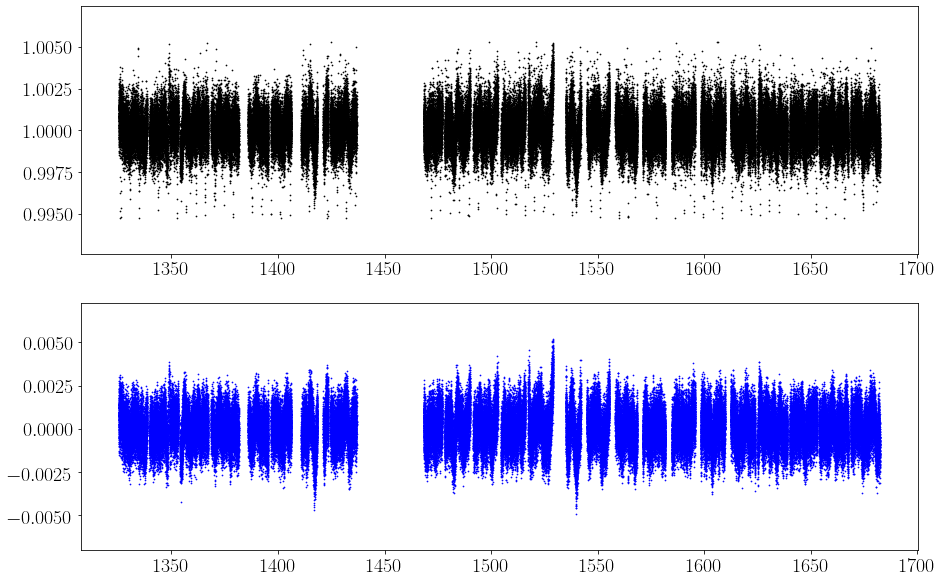

In [54]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
ax1.scatter(time1,flux1,s=.5,color='k')
ax2.scatter(time,flux,s=.5,color='b')

(10, 10) [[ 4.48183708  7.21265478  2.23877391  3.8513706   2.22644701 12.69251663
  19.78580229 16.14287873 10.33250634 12.56516241]
 [16.66763943  9.15258131 18.38749346  2.84164086  2.74524166 18.26154162
   4.95624032  0.27652201 19.08485326  1.09881863]
 [ 1.66126821 10.5543594  16.02113707  6.69103427 12.37960903 12.87663157
  12.61095514  7.53883554  6.66110362  3.20860294]
 [ 1.85185037 15.72648236  9.60803499 12.27788185  7.04658395  8.17875135
  15.59417608  7.86762347  5.9028816   5.54277861]
 [ 0.12040148  8.29307764 10.02250498 14.11819309  0.09868833  9.43958864
   4.37558491 19.57184163 18.78348972  4.57708632]
 [ 2.06737819  1.73588233 11.91131086  4.41736718 16.09910834  1.0963451
   1.18545488  1.38840886 19.6935963  19.64924405]
 [10.78061378 11.74936281 16.83375242 18.85311223 12.09297973 15.70198675
   4.13533695  3.85230475 15.58811408  9.2549384 ]
 [19.80393442 10.27723022  9.84138842  4.4434883  14.96002754 14.0269012
  18.02202297 13.66141568  8.24928887  9.424

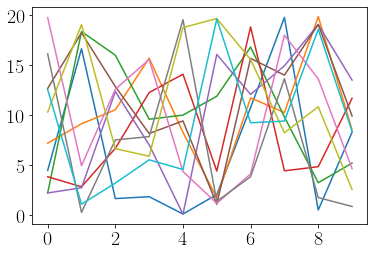

In [10]:
data = np.random.rand(10, 10) * 20
print(data.shape,data)
plt.plot(data);